In [66]:
import numpy as np
import kagglehub
import scipy.io
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [67]:
# Download latest version
path = kagglehub.dataset_download("dkrivosic/leeds-sports-pose-lsp")
print("Path to dataset files:", path)

Path to dataset files: /Users/lionelseoanerollan/.cache/kagglehub/datasets/dkrivosic/leeds-sports-pose-lsp/versions/1


In [68]:
# Load the .mat annotation file
annotations = scipy.io.loadmat(f'{path}/joints.mat')

# Extract keypoints from 'joints'
joints = annotations['joints']

# Image Folder
image_folder = f'{path}/images/'

# Joints vector [3[14[2000]]]
num_images = len(joints[0][0])

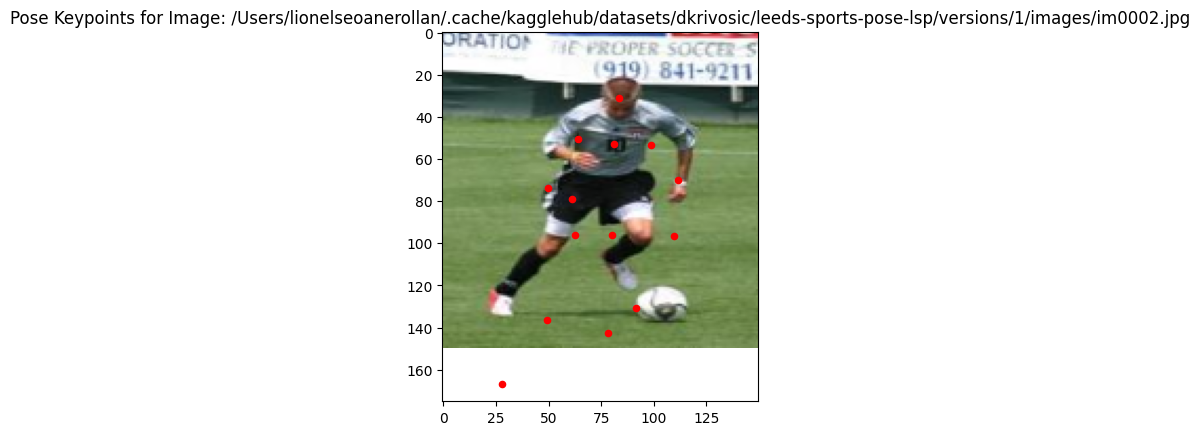

In [79]:
# Example: Load the first image and its corresponding keypoints
index = 1

# Construct the image path based on the naming convention
image_path = os.path.join(image_folder, f'im{index + 1:04d}.jpg')  # 'im0001.jpg', 'im0002.jpg', etc.

# Load the image using OpenCV
img = cv2.imread(image_path)
img = cv2.resize(img, (150,150))

# Get the keypoints for the current image
keypoints = joints[:, :, index]  # Access the keypoints for the image at index

# Plot the image with keypoints
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display in matplotlib

# Loop over each joint and plot its (x, y) coordinates
for i in range(14):  # Loop over the 14 joints
    x = keypoints[0, i]  # X coordinate
    y = keypoints[1, i]  # Y coordinate
    plt.scatter(x, y, color='red', s=20)  # Plot the keypoints as red dots

plt.title(f'Pose Keypoints for Image: {image_path}')
plt.show()

In [70]:
indices = np.arange(num_images)

# Split the data into train (80%) and test (20%)
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

print(f"Number of training samples: {len(train_indices)}")
print(f"Number of test samples: {len(test_indices)}")

# Function to load images given a list of indices
def load_images(indices, image_folder, target_size=(150, 150)):
    images = []
    
    for idx in indices:
        # Construct image file path
        image_path = os.path.join(image_folder, f'im{idx + 1:04d}.jpg')  # Example: 'im0001.jpg'
        
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        
        if image is not None:
            # Resize image to a consistent shape (e.g., 224x224)
            image = cv2.resize(image, target_size)
            
            # Convert BGR to RGB (OpenCV loads in BGR by default)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            images.append(image)
        else:
            print(f"Warning: Image {image_path} could not be loaded.")
    
    # Convert the list of images into a numpy array (now they will all have the same shape)
    return np.array(images)

# Load training and test images
train_images = load_images(train_indices, image_folder)
test_images = load_images(test_indices, image_folder)

# Normalize keypoints (assuming max image size is 150x150)
def normalize_keypoints(keypoints, image_size=150):
    # Normalize x, y to be between [0, 1]
    keypoints[0] = keypoints[0] / image_size  # x-coordinates
    keypoints[1] = keypoints[1] / image_size  # y-coordinates
    return keypoints

# Now prepare the keypoints
train_keypoints = joints[:2, :, train_indices]  # (2, 14, num_train_samples)
test_keypoints = joints[:2, :, test_indices]    # (2, 14, num_test_samples)

print(train_images.shape)
print(train_keypoints.shape)

Number of training samples: 1600
Number of test samples: 400
(1600, 150, 150, 3)
(2, 14, 1600)


In [76]:
joints[:2, :, 1]

array([[ 28.12031897,  49.17944312,  62.60463477,  80.24165125,
         91.56093048,  78.39897788,  61.28843951,  49.96916028,
         63.92083003,  98.66838488, 111.30385937, 109.46118601,
         81.0313684 ,  83.40051987],
       [166.65510177, 136.64584985,  95.84379681,  96.10703586,
        130.85459071, 142.70034805,  78.99649749,  73.73171645,
         50.56667988,  53.46230945,  69.78313067,  96.37027491,
         52.6725923 ,  30.82375099]])

In [72]:
# Reshaping images
train_images = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2)
test_images = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)
print(train_images.shape)

# Reshaping keypoints
train_keypoints = torch.tensor(train_keypoints, dtype=torch.float32)
test_keypoints = torch.tensor(test_keypoints, dtype=torch.float32)

train_keypoints = train_keypoints.permute(2, 1, 0)  # Change shape to (1600, 14, 2)
train_keypoints = train_keypoints.reshape(-1, 28)    # Reshape to (1600, 28)

test_keypoints = test_keypoints.permute(2, 1, 0)  # Change shape to (1600, 14, 2)
test_keypoints = test_keypoints.reshape(-1, 28)    # Reshape to (1600, 28)

print(train_keypoints.shape)

torch.Size([1600, 3, 150, 150])
torch.Size([1600, 28])


In [73]:
train_dataset = TensorDataset(train_images, train_keypoints)
test_dataset = TensorDataset(test_images, test_keypoints)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [74]:
class KeypointCNN(nn.Module):
    def __init__(self):
        super(KeypointCNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Third Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 18 * 18, 512)  # Adjust the size after pooling (depends on input size)
        self.fc2 = nn.Linear(512, 28)  # Output: 28 values (14 keypoints * 2 coordinates, X and Y)

    def forward(self, x):
        # Apply first convolutional block
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # Apply second convolutional block
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Apply third convolutional block
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Flatten the output for the fully connected layer
        x = x.view(-1, 128 * 18 * 18)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Final output (28 values: 14 keypoints * 2 coordinates)
        
        return x

In [50]:
batch_size = 64
# Initialize the model
model = KeypointCNN()

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        # Move data to GPU if available
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print training progress
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader)}")

# Save the trained model
torch.save(model.state_dict(), "keypoint_cnn.pth")

Epoch [1/10], Loss: 521.7304126884043
Epoch [2/10], Loss: 0.05338963538408279
Epoch [3/10], Loss: 0.04277919888496399
Epoch [4/10], Loss: 0.036892423182725904
Epoch [5/10], Loss: 0.033800333738327026
Epoch [6/10], Loss: 0.030282304063439368
Epoch [7/10], Loss: 0.02759516067802906
Epoch [8/10], Loss: 0.02279771029949188
Epoch [9/10], Loss: 0.01988352380692959
Epoch [10/10], Loss: 0.01762551788240671


[[-0.03325542  0.05919656 -0.01485033]
 [ 0.01136404  0.00371248  0.01158671]
 [ 0.0043789  -0.01949895 -0.0013959 ]
 [-0.02182506  0.0756574   0.04878854]
 [ 0.03752706  0.02413887  0.00757573]
 [ 0.04483442  0.00900772 -0.0213007 ]
 [ 0.03596622 -0.01105726  0.04320436]
 [ 0.02746751  0.02523491  0.00924097]
 [-0.00068781  0.01320024  0.04061499]
 [ 0.040003    0.02375703  0.01461768]
 [ 0.0161978   0.01943549  0.04920901]
 [ 0.00153894  0.00114957  0.01607412]
 [-0.01848359  0.01729128 -0.0388337 ]
 [ 0.01509401  0.03976994  0.02993062]]


/var/folders/49/zw05y1bx6p17h5qlxkv4xl4r0000gn/T/ipykernel_50981/1859791433.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("keypoint_cn

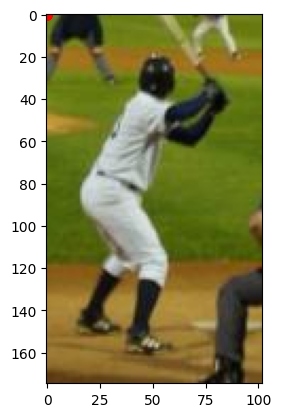

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Assume the model is already defined as KeypointCNN and you've trained it.
# Load the trained model (adjust the path to your model file)
model = KeypointCNN()
model.load_state_dict(torch.load("keypoint_cnn.pth"))
model.eval()  # Set the model to evaluation mode

# Preprocess the input image (single image)
index = 4
image_path = os.path.join(image_folder, f'im{index + 1:04d}.jpg')  # 'im0001.jpg', 'im0002.jpg', etc.
image = plt.imread(image_path)  # Read the image

# Resize and normalize the image as needed (use your preprocessing steps)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL image
    transforms.Resize((150, 150)),  # Resize image to 150x150
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Apply transformations
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension (shape: [1, 2, 150, 150])

# Make prediction with the trained model
with torch.no_grad():  # No need to compute gradients during inference
    output = model(image_tensor)  # Get the model's output (predicted keypoints)

# The output will be of shape (1, 42) - a flattened vector of 42 keypoint coordinates
predicted_keypoints = output.squeeze().cpu().numpy()  # Convert output to numpy array

# Reshape to (14, 3) for better visualization (14 keypoints, each with 3 coordinates: X, Y, Z)
predicted_keypoints = predicted_keypoints.reshape(14, 3)

# Print the predicted keypoints
print(predicted_keypoints)

# Optional: Visualize the keypoints on the image (if you want to visualize it)
plt.imshow(image)
for i in range(14):
    plt.scatter(predicted_keypoints[i, 0], predicted_keypoints[i, 1], c='r')  # Red dots for keypoints
plt.show()